# Assignment — Centrality measures

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Dict, List

In this assignment, we will use Moscow Metro underground stations dataset taken from [Moscow Subway Optimal* Complete Route](https://medium.com/altsoph/moscow-subway-optimal-complete-route-ac98796dd652) research. Let us download and take a look at the data.

In [56]:
station_url = 'https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/datasets/stations_data.txt'
routes_url = 'https://raw.githubusercontent.com/netspractice/ml-on-graphs/main/datasets/routes_data.txt'

In [57]:
stations = pd.read_csv(station_url)
routes = pd.read_csv(routes_url)

In [58]:
stations.head()

,id,line_name,station_name,station_type,delay_morning,delay_rush,delay_night,lat,lon
0,0,Sokolnicheskaya,Bulvar Rokossovskogo,deadend,120,90,360,55.814269,37.735117
1,1,Sokolnicheskaya,Cherkizovskaya,pass,120,90,360,55.802991,37.744825
2,2,Sokolnicheskaya,Preobrazhenskaya ploschad,pass,120,90,360,55.796172,37.715022
3,3,Sokolnicheskaya,Sokolniki,pass,120,90,360,55.789200,37.679706
4,4,Sokolnicheskaya,Krasnoselskaya,pass,120,90,360,55.779853,37.666077


In [59]:
routes.head()

,id_from,id_to,route_type,delay
0,0,1,drive,120
1,1,0,drive,120
2,1,2,drive,240
3,2,1,drive,240
4,2,3,drive,180


### Task 1. Metro graph (0.8 points)

Before we start analyzing centrality, let us build a graph of stations.

Write a function `metro_graph` that takes datasets `stations` and `routes` and returns a graph with all stations and routes of any type. Labels of nodes are in column `stations.id`. Nodes in `G.nodes` viewer should be in ascending order. All nodes should have attributes `station_name` and `line_name`.

In [60]:
def metro_graph(stations: pd.DataFrame, routes: pd.DataFrame) -> nx.Graph:
    """
    Build a graph with metro stations and routes
    
    :param stations: dataframe with undeground stations (nodes) description, column id is used for node id in the nx.Graph
    :param routes: edgelist for undeground graph. id_from is source and id_to is target nodes.
    :return: graph of Moscow undeground
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    G = nx.Graph()
    G.add_nodes_from(stations["id"].to_numpy())
    G.add_edges_from(routes[["id_from", "id_to"]].to_numpy())
    nx.set_node_attributes(G, stations["station_name"].to_dict(), "station_name")
    nx.set_node_attributes(G, stations["line_name"].to_dict(), "line_name")
    return G

In [61]:
'''Check ordering of nodes, number of nodes, names of stations and lines'''
G = metro_graph(stations, routes)
assert (np.array(list(G.nodes)) == np.arange(194)).sum() == 194
assert G.number_of_edges() == 228
assert G.nodes[100]['station_name'] == 'Shabolovskaya'
assert G.nodes[100]['line_name'] == 'Kaluzhsko-Rizhskaya'

Let us draw the graph with default spring layout.

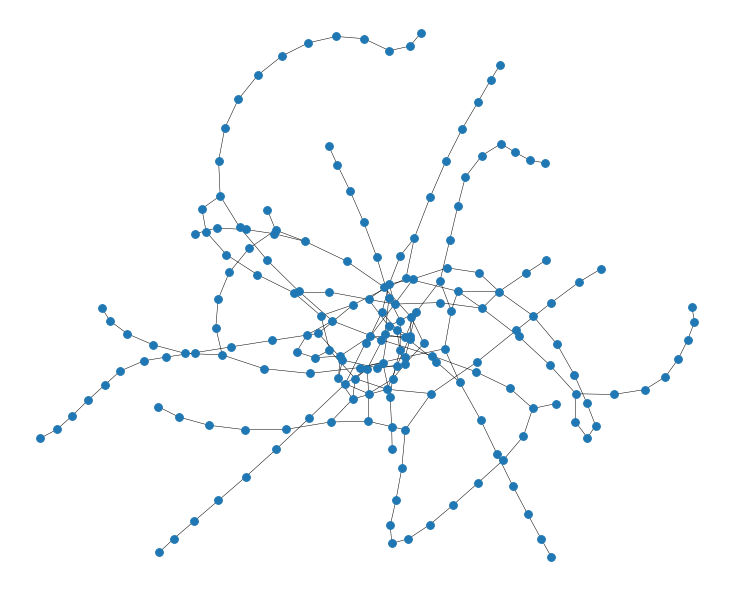

In [62]:
plt.figure(figsize=(10, 8))
nx.draw(G, 
        width=0.5,
        node_size=60)
plt.show()

So far it does not look like a metro map. Let us specify a distance based layout using information from the dataset `stations`.

Write a function `metro_layout` that takes the dataset `stations` and returns a dictionary with nodes as keys and positions as values:
```
{node_id: [longitude, latitude]}
```

In [63]:
def metro_layout(stations: pd.DataFrame) -> Dict[int, List[float]]:
    """
    Build a distance based layout of the metro graph
    
    :param stations: dataframe with undeground stations (nodes) description, column id is used for node id in the nx.Graph.
        lat and lon is geo coordinates of station.
    :return: geo layout of Moscow undeground
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    layout = {}
    for row in stations.itertuples():
        layout[row.id] = [row.lon, row.lat]

    return layout

In [64]:
'''Check a type and positions of some random nodes'''
pos = metro_layout(stations)
assert type(pos) == dict
assert len(pos) == 194
assert pos[100] == [37.6078018, 55.71882329]
assert pos[172] == [37.72840065, 55.69297728]

Let us draw the graph with the distance based layout.

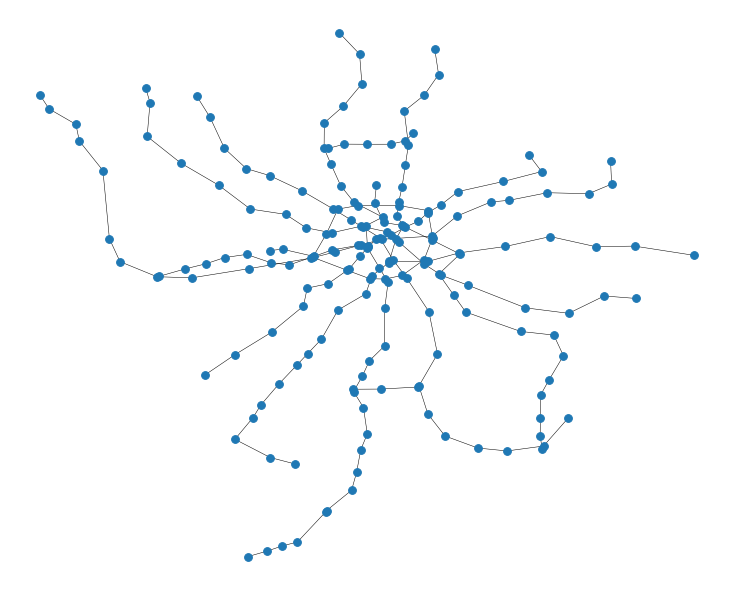

In [65]:
plt.figure(figsize=(10, 8))
nx.draw(G, 
        pos,
        width=0.5,
        node_size=60)
plt.show()

The final preprocessing step, let us colorize stations by their lines.

Write a function `station_color` that takes a graph `G` and returns a dictionary with nodes as keys and color as values. Colors are given in the `line_color` dictionary.

In [66]:
line_color = {
    'Sokolnicheskaya': 'tab:red',
    'Zamoskvoretskaya': 'tab:green',
    'Arbatsko-Pokrovskaya': 'tab:blue',
    'Filevskaya': 'deepskyblue',
    'Koltsevaya': 'tab:brown',
    'Kaluzhsko-Rizhskaya': 'tab:orange',
    'Tagansko-Krasnopresnenskaya': 'tab:purple', 
    'Kalininskaya': 'gold',
    'Serpuhovsko-Timiryazevskaya': 'gray', 
    'Lyublinsko-Dmitrovskaya': 'yellowgreen',
    'Kahovskaya': 'paleturquoise', 
    'Butovskaya': 'lightblue', 
    'Monorels': 'royalblue'
}

In [67]:
def station_color(G: nx.Graph, line_color: Dict[str, str] = line_color) -> Dict[int, str]:
    """
    Defines color of stations
    
    :param G: graph of Moscow undeground
    :param line_color: mapping of undeground lines to colors
    :return: mapping of node ids to its colors 
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    layout = {}
    for row in stations.itertuples():
        layout[row.id] = line_color[row.line_name]

    return layout

In [68]:
'''Check a type and colors of some random nodes'''
nx.set_node_attributes(G, station_color(G), 'color')
assert type(station_color(G)) == dict
assert len(station_color(G)) == 194
assert station_color(G)[9] == 'tab:red'
assert station_color(G)[193] == 'royalblue'
assert station_color(G)[119] == 'tab:purple'

Let us draw the graph with the distance based layout and stations colors.

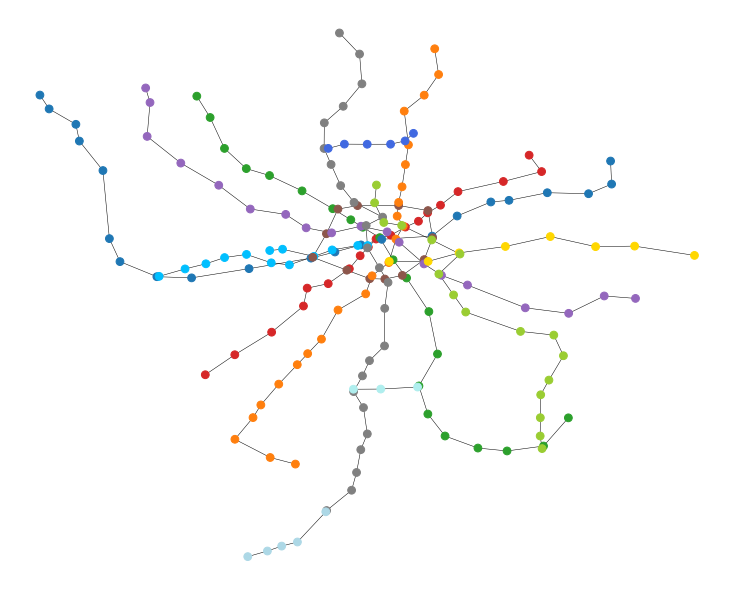

In [69]:
plt.figure(figsize=(10, 8))
nx.draw(
    G, 
    pos,
    width=0.5,
    node_color=list(nx.get_node_attributes(G, 'color').values()),
    node_size=60,
)
plt.show()

### Task 2. Degree, closeness, betweenness centralities (0.8 point)

Let us look at centrality measures of the metro stations graph. First, use networkx to calculate degree, closeness, betweenness centralities.

Write a function `centralities` that takes a graph `G` and returns a dictionary with keys `degree`, `closeness`, `betweenness`. The values are np.arrays with values of each centrality.

In [70]:
def centralities(G: nx.Graph) -> Dict[str, np.array]:
    """
    Calculate degree, closeness, betweenness centralities of the graph
    
    :param G: Moscow undeground graph
    :return: mapping of centrality names (degree, closeness, betweenness) to np.array of its values
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    degree = np.array(list(nx.degree_centrality(G).values()))
    closeness = np.array(list(nx.closeness_centrality(G).values()))
    betweenness = np.array(list(nx.betweenness_centrality(G).values()))
    return {
        'degree': degree,
        'closeness': closeness,
        'betweenness': betweenness,
    }

In [71]:
'''Check some random values of centralities'''
c = centralities(G)
assert c['degree'].shape[0] == 194
assert c['degree'][193] == 0.0051813471502590676
assert c['closeness'][94] == 0.12107904642409034
assert c['betweenness'][49] == 0.0991400402993669

Next, let us create a table with top 10 nodes for each centrality.

Write a function `top10_centralities` that takes a graph `G` and returns a dictionary with keys `degree`, `closeness`, `betweenness`. The values are pd.DataFrames with columns:
* `station` — station name
* `line` — line name
* `centrality` — value of a centrality

Each dataframe contains 10 rows with highest centrality values.

In [72]:
def top10_centralities(G: nx.Graph) -> Dict[str, pd.DataFrame]:
    """
    Create table of top 10 nodes by degree, closeness, betweenness centralities
    
    :param G: graph of Moscow undeground
    :return: mapping of station name to the dataframe with columns (station, line, centrality)
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    cases = [['degree', nx.degree_centrality(G)], 
             ['closeness', nx.closeness_centrality(G)], 
             ['betweenness', nx.betweenness_centrality(G)]]
    dfs = {}
    for title, centrality in cases:
        top = sorted(centrality.items(), key=lambda i: i[1], reverse=True)[:10]
        station_name = [G.nodes[i]['station_name'] for i, val in top]
        line_name = [G.nodes[i]['line_name'] for i, val in top]
        centr_value = [val for i, val in top]
        dfs[title] = pd.DataFrame({'station': station_name, 
                                   'line': line_name, 
                                   'centrality': centr_value})
    return dfs

In [73]:
'''Check that some random nodes are in the top 10 tables'''
top_dfs = top10_centralities(G)
assert 'Biblioteka imeni Lenina' in top_dfs['degree']['station'].to_list()
assert 'Serpuhovskaya' in top_dfs['betweenness']['station'].to_list()
assert 'Teatralnaya' in top_dfs['closeness']['station'].to_list()
assert 'Arbatsko-Pokrovskaya' in top_dfs['closeness']['line'].to_list()

Following code makes a visualization: for each centrality it prints a top 10 table and graph, where the node size and color correspond to the centrality value.

Degree centrality


,station,line,centrality
0,Biblioteka imeni Lenina,Sokolnicheskaya,0.025907
1,Arbatskaya,Arbatsko-Pokrovskaya,0.025907
2,Kievskaya,Filevskaya,0.025907
3,Chistye prudy,Sokolnicheskaya,0.020725
4,Tverskaya,Zamoskvoretskaya,0.020725
5,Teatralnaya,Zamoskvoretskaya,0.020725
6,Novokuznetskaya,Zamoskvoretskaya,0.020725
7,Kurskaya,Arbatsko-Pokrovskaya,0.020725
8,Kievskaya,Arbatsko-Pokrovskaya,0.020725
9,Taganskaya,Koltsevaya,0.020725


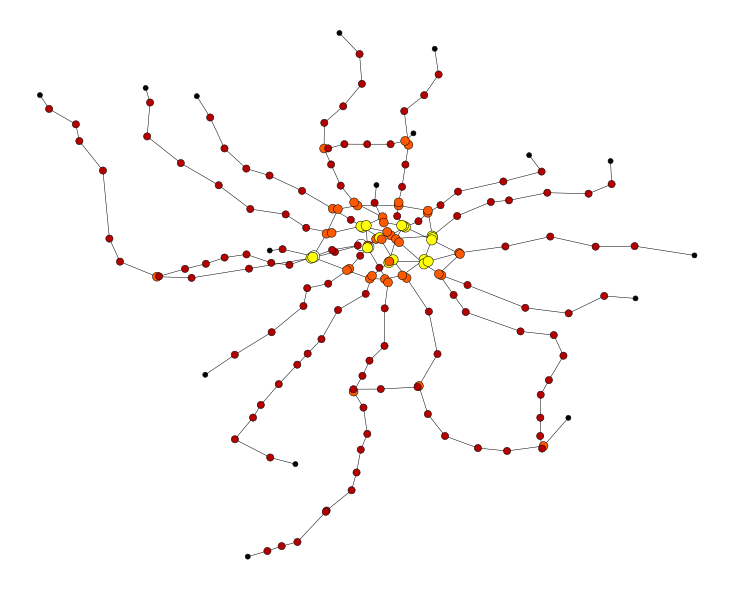

Closeness centrality


,station,line,centrality
0,Teatralnaya,Zamoskvoretskaya,0.141288
1,Ploschad Revolyutsii,Arbatsko-Pokrovskaya,0.141185
2,Novokuznetskaya,Zamoskvoretskaya,0.139350
3,Taganskaya,Koltsevaya,0.138849
4,Kurskaya,Koltsevaya,0.138849
5,Arbatskaya,Arbatsko-Pokrovskaya,0.138451
6,Chehovskaya,Serpuhovsko-Timiryazevskaya,0.137956
7,Paveletskaya,Koltsevaya,0.137857
8,Dobryninskaya,Koltsevaya,0.137464
9,Tretyakovskaya,Kaluzhsko-Rizhskaya,0.137269


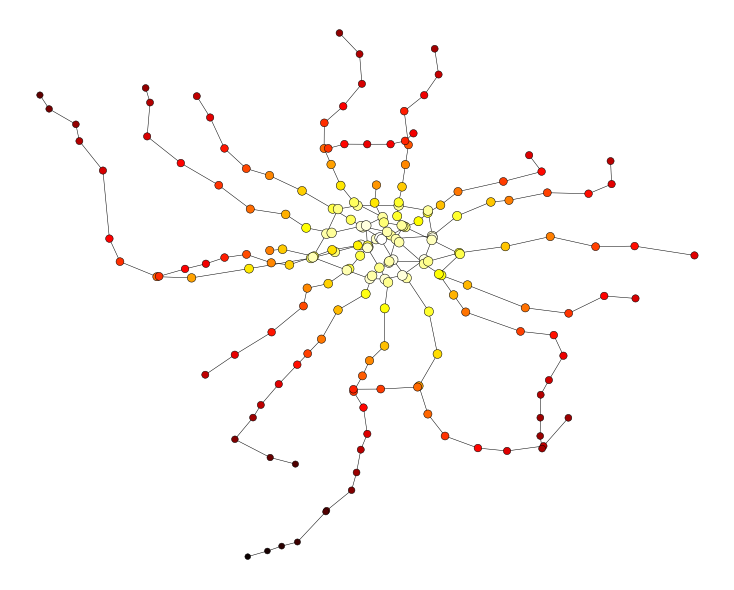

Betweenness centrality


,station,line,centrality
0,Kievskaya,Koltsevaya,0.172276
1,Serpuhovskaya,Serpuhovsko-Timiryazevskaya,0.144095
2,Kievskaya,Arbatsko-Pokrovskaya,0.133394
3,Tulskaya,Serpuhovsko-Timiryazevskaya,0.130192
4,Park kultury,Koltsevaya,0.130139
5,Dobryninskaya,Koltsevaya,0.129763
6,Oktyabrskaya,Koltsevaya,0.124274
7,Oktyabrskaya,Kaluzhsko-Rizhskaya,0.122584
8,Nagatinskaya,Serpuhovsko-Timiryazevskaya,0.122204
9,Krasnopresnenskaya,Koltsevaya,0.122121


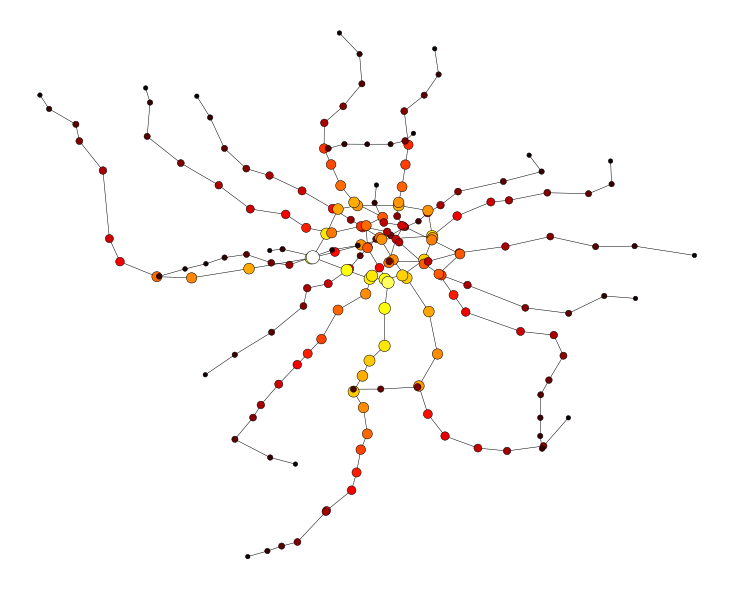

In [74]:
cases = [['degree', 5000, 0, 'Degree centrality'], 
         ['closeness', 700, 0, 'Closeness centrality'], 
         ['betweenness', 900, 20, 'Betweenness centrality']]
for c_key, scale, bias, title in cases:
    print(title)
    display(top_dfs[c_key])
    plt.figure(figsize=(10, 8))
    nx.draw(G, 
            pos,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            cmap=plt.cm.hot,
            node_size=c[c_key]*scale + bias,
            node_color=c[c_key])
    plt.show()

### Task 3. Center of the graph (0.8 points)

In the next section we will slightly modify the initial graph — truncate all stations that located outside of Sadovoye ring.
Sadovoye ring is the region that includes all stations on the Koltsevaya line, all stations of radial lines that intersect Koltsevaya line and all stations that contains inside the circle.

Write a function `metro_graph_center` that takes a metro graph `G` and returns a subgraph with stations inside Sadovoye ring.

In [75]:
def metro_graph_center(G: nx.Graph) -> nx.Graph:
    """
    Build a subgraph with stations inside the Sadovoye ring
    
    :param G: graph of Moscow undeground
    :return: subgraph of Moscow undeground stations that is located inside Sadovoye ring.
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    rr = 0.112
    c = centralities(G)
    nodes = []
    for i in G.nodes:
        if c['closeness'][i] > rr:
            
            nodes.append(i)
    G = G.subgraph(nodes).copy() 
    for i in list(G.nodes):
        if G.degree[i] == 1:
            G.remove_node(i)
    for i in [169, 124, 135, 168]:    
        G.remove_node(i)
    return G

In [76]:
'''Check the number of nodes and edges and some random stations'''
subG = metro_graph_center(G)
assert len(subG.nodes) == 57
assert len(subG.edges) == 85
assert 149 in list(subG.nodes)
assert 82 in list(subG.nodes)
assert 137 in list(subG.nodes)

Let us draw the center of the metro graph with station names and colors.

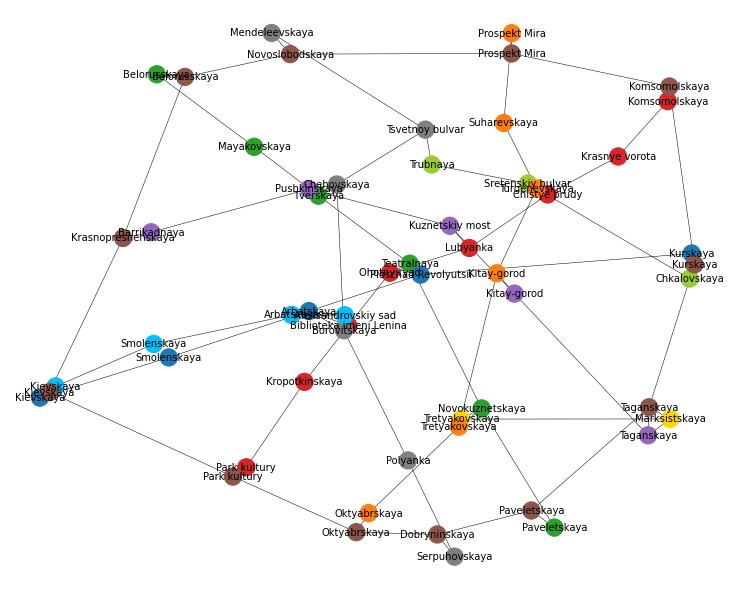

In [77]:
plt.figure(figsize=(10, 8))
nx.draw(subG, 
        pos,
        width=0.5,
        node_color=list(nx.get_node_attributes(subG, 'color').values()),
        labels=nx.get_node_attributes(subG, 'station_name'),
        font_size=10)
plt.show()

### Task 4. Centralization (2 point)

The center of the metro graph looks a bit like a circular graph. We can see that a circular graph has the lowest centralization since

$$\text{Centralization} = \frac{\sum_i^N[C_x(p_*) - C_x(p_i)]}{\max\sum_i^N[C_x(p_*) - C_x(p_i)]}$$

where 
* $C_x$ — some centrality measure
* $p_i$ — $i$-th node
* $p_*$ — node with the largest centrality value
* $\max$ — maximum over all possible graphs with the same number of nodes (a star graph for degree, betweenness, closeness centralities).

Let us check how centralization changes during transformation our truncated graph into a pure circular graph.

Write a function `centralization_seq` that takes the truncated graph `G` and deletes stations inside Koltsevaya line one-by-one in ascending order (i.e. result of `sorted` function). In each step the centralization is calculated. The function returns a dictionary with keys `degree`, `closeness`, `betweenness` and values — np.arrays with centralization values.

In [98]:
def centralization_seq(G: nx.Graph) -> (Dict[str, np.array], List[str]):
    """
    Delete stations and calculate centralization for degree, closeness, betweenness
    
    :param G: graph of Moscow undeground inside the Sadovoye ring
    :return: to elements (tuple):
        1. mapping of centrality name to array of centralization values for subgraphs
           without each node (iteratively) that does not correspond to Koltsevaya line
        2. list of station ids to remove
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    cases = ['degree', 'closeness', 'betweenness']
    cent = {}
    ids = sorted([i for i in list(G.nodes) if G.nodes[i]['line_name'] != 'Koltsevaya'])
    order = [G.nodes[i]['station_name'] for i in ids]
    for title in cases:
        graph = G.copy()
        cs = []
        for i in ids:
          graph.remove_node(i)
          c = centralities(graph)[title]
          star = nx.star_graph(len(list(graph.nodes)) - 1)
          star_c = centralities(star)[title]
          C = (max(c) - c).sum() / (max(star_c) - star_c).sum()
          cs.append(C)
        cent[title] = np.array(cs)
    return cent, order

In [99]:
'''Check the output shape and some random centralization values'''
cent, order = centralization_seq(subG)
assert cent['degree'].shape == (45,)
assert cent['closeness'].shape == (45,)
assert cent['betweenness'].shape == (45,)
assert cent['degree'][-1] == cent['betweenness'][-1] == cent['closeness'][-1]
assert cent['degree'][41].round(4) == 0.0824
assert cent['degree'][2].round(4) == 0.0406
assert cent['closeness'][11].round(4) == 0.0785
assert cent['closeness'][9].round(4) == 0.0814
assert cent['betweenness'][14].round(4) == 0.1178

Let us draw how the centralization changes when the graph tends to a circular graph.

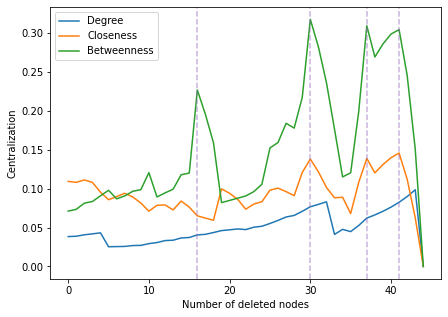

In [100]:
plt.figure(figsize=(7, 5))
plt.plot(cent['degree'], label='Degree')
plt.plot(cent['closeness'], label='Closeness')
plt.plot(cent['betweenness'], label='Betweenness')
plt.ylabel('Centralization')
plt.xlabel('Number of deleted nodes')
plt.axvline(16, linestyle='--', color='C4', alpha=0.5)
plt.axvline(30, linestyle='--', color='C4', alpha=0.5)
plt.axvline(37, linestyle='--', color='C4', alpha=0.5)
plt.axvline(41, linestyle='--', color='C4', alpha=0.5)
plt.legend()
plt.show()

We can see the several peaks in centralization for betweenness centrality. Higher centralization means that centrality measures unevenly distributed over nodes. Betweenness centrality for specific node indocates how much shortest paths pass through this node.

Peaks signalize that we break some shortests paths after node deletion, so new shortest paths should go through a little number of specific nodes.

Let us visualize graph before and after deletion of node under index `37` (Tsvetnoy bulvar), to understand this effect.

In [101]:
def plot_truncated_graph(subG, order, idx, ax, highlight=True, title=""):
    s = subG.copy()
    s.remove_nodes_from(order[:idx + 1])
    betw = nx.betweenness_centrality(s)
    nx.draw(
        s,
        pos,
        width=0.5,
        node_color=list('red' if (i == order[idx + 1] and highlight) else j
                        for i, j in nx.get_node_attributes(s, 'color').items()),
        node_size=[j * 1000 for i, j in betw.items()],
        labels=nx.get_node_attributes(s, 'station_name'),
        font_size=10,
        ax=ax
    )
    ax.set_title(title)

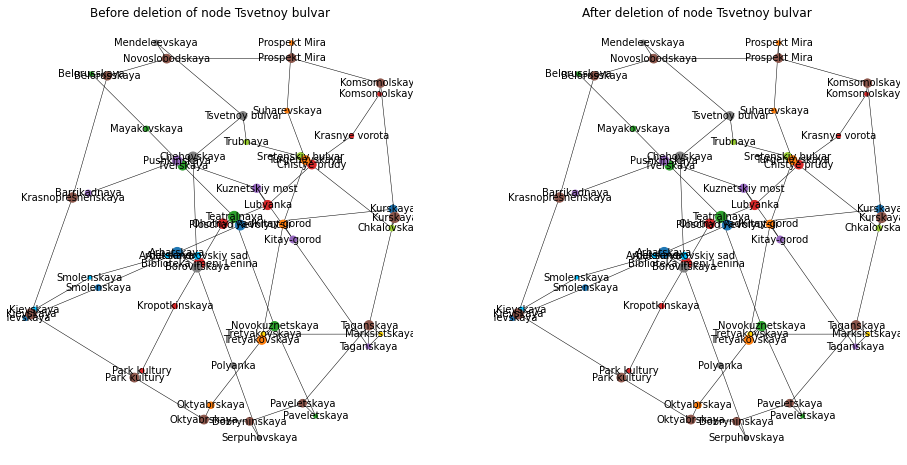

In [103]:
f = plt.figure(figsize=(16, 8))
ax = f.subplots(1, 2)
plot_truncated_graph(subG, order, 36, ax[0], title="Before deletion of node Tsvetnoy bulvar")
plot_truncated_graph(subG, order, 37, ax[1], highlight=False, title="After deletion of node Tsvetnoy bulvar")

Tsvetnoy bulvar is a node targeted for deletion on the next step.

On the first graph we can see, that exists a cycle of gray and light green line, so all nodes on that lines can easily access each other via shortest path.

However, after deletion of Tsvetnoy bulvar, the cycle is broken. So to connect stations between gray and light green lines, it is required to pass through line intersection with Koltsevaya and some stations on it. It raises the value of betwenness centrality for such nodes (e.g. Serpuhovskaya, Paveletskaya, Taganskaya), keeping the old values for rest of graph. So it leads to the increase of overall graph centralization for betwenness centrality.

### Task 5. Katz centrality (3 points)

Katz centrality is based on the number of all paths (not only shortest) passing through a node. By the way, how to quickly calculate the total number of fixed length paths between two nodes?

Write a function `number_of_paths` that takes graph `G`, nodes `i`, `j` and the length of paths `n`. The function returns the number of paths.

In [ ]:
def number_of_paths(G: nx.Graph, i: int, j: int, n: int) -> int:
    """
    Calculate number of paths of length n
    
    :param G: graph of Moscow underground inside the Sadovoye ring
    :param i: the starting node of paths
    :param j: the target node of paths
    :param n: the size of paths
    :return: the number of paths between input nodes of size n
    """
    # YOUR CODE HERE
    #raise NotImplementedError()

In [ ]:
'''Check some paths in the city center'''
# Paveletskaya (Koltsevaya) - Ohotny ryad. Length 4
# Single path: Paveletskaya (Koltsevaya) -> Paveletskaya (Zamoskvoretskaya) 
# -> Novokuznetskaya -> Teatralnaya -> Ohotny ryad
assert number_of_paths(subG, 78, 9, 4) == 1
# Novoslobodskaya - Pushkinskaya. Length 4
# 1st path: Novoslobodskaya -> Belorusskaya -> Krasnopresnenskaya
# -> Barrikadnaya -> Pushkinskaya
# 2nd path: Novoslobodskaya -> Mendeleevskaya -> Tsvetnoy bulvar
# -> Chehovskaya -> Pushkinskaya
assert number_of_paths(subG, 83, 120, 4) == 2
# Novoslobodskaya - Pushkinskaya. Length 7. Many paths.
assert number_of_paths(subG, 83, 120, 7) == 31

Now we can apply similar approach in calculation Katz centrality. The formula is

$$k_i = \beta\sum_j A_{ij} + \beta^2\sum_j A_{ij}^2 + \beta^3\sum_j A_{ij}^3 + \dots$$

where $\beta$ is an attenuation factor with restriction 

$$\beta < \frac{1}{\lambda}$$

where $\lambda$ is a largest eigenvalue of a matrix $A$.

Write a function `katz_centrality` that takes a graph `G`, number of iterations `n`, attenuation factor `beta` and returns a np.array of centrality values.

In [ ]:
def katz_centrality(G: nx.Graph, n: int, beta: float) -> np.array:
    """
    Calculate Katz centrality
    
    :param G: graph of Moscow undeground
    :param n: number of iterations in Katz centrality calcultation
    :param beta: attenuation factor
    :return: array of centrality values for each node
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
'''Check the restriction on beta and networkx implementation'''
beta = 1 / 3
try:
    katz = katz_centrality(G, 1, beta)
except:
    pass
else:
    raise AssertionError("Did not raise an exception")
beta = 1 / 5
assert 0.9999 < np.corrcoef(katz_centrality(G, 1, beta), c['degree'])[0][1] <= 1
nxkatz = np.array([val for val in nx.katz_centrality(G, beta).values()])
assert 0.9999 < np.corrcoef(katz_centrality(G, 20, beta), nxkatz)[0][1] <= 1

Let us draw the graph with Katz centrality visualization.

In [ ]:
katz_c = katz_centrality(subG, 20, 1/4)
katz_c = katz_c / katz_c.max()
plt.figure(figsize=(8, 6))
nx.draw(subG, 
        pos,
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.hot,
        node_size=katz_c*300,
        node_color=katz_c)
plt.show()

Here we can see how Katz centrality converges by the number of iterations.

In [ ]:
plt.figure(figsize=(7, 5))
convergence = []
old_katz = katz_centrality(G, 1, 0.2)
step_space = np.arange(2, 21)
for i in step_space:
    katz = katz_centrality(G, i, 0.2)
    convergence.append(np.linalg.norm(katz - old_katz))
    old_katz = katz.copy()
plt.plot(step_space, convergence)
plt.ylabel('Difference, Euclidean norm')
plt.xlabel('Step')
plt.title('Convergence of Katz centrality')
plt.show()

### Task 6. Eigenvector centrality (2 points)

Let us implement eigenvector centrality that can be interpreted as influence of a node. A centrality value of a node takes into account centrality values of its neighbors, that is

$$v_i = \frac{1}{\lambda}\sum_j A_{ij} v_j$$

or in the matrix form

$$Av = \lambda v$$

where $\lambda$ is the largest eigenvalue.

Write a function `eigenvector_centrality` that takes an adjacency matrix `A` and returns a np.array with centrality values.

In [ ]:
def eigenvector_centrality(A: np.array) -> np.array:
    """
    Calculate eigenvector centrality
    
    :param A: adjacency matric of graph
    :return: array of eigenvector centralities
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
'''Check some random values'''
eig_c = eigenvector_centrality(nx.to_numpy_array(subG))
assert eig_c.shape == (57, )
assert eig_c[0].round(4) == 0.0244
assert eig_c[-1].round(4) == 0.0701
assert eig_c[25].round(4) == 0.1198

Let us draw the graph with eigenvector centrality visualization.

In [ ]:
plt.figure(figsize=(8, 6))
nx.draw(subG, 
        pos,
        width=0.5,
        linewidths=0.5,
        edgecolors='black',
        cmap=plt.cm.hot,
        node_size=eig_c/eig_c.max()*400,
        node_color=eig_c)
plt.show()

### Task 7. Correlations (0.6 point)

Finally, let us see the relation between centralities. Calculate Pearson correlation coefficient and then we will draw scatter plots on pairs of centralities.

Write a function `pearson_correlation` that takes two np.arrays and returns Person correlation coefficient.

In [ ]:
def pearson_correlation(i_vals: np.array, j_vals: np.array) -> float:
    """
    Calculate Pearson correlation coefficient
    
    :param i_vals: array of centralities
    :param j_vals: array of centralities
    :return: Pearson's correlation
    """
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
'''Check some coefficients'''
centvals = [
    ('Degree', list(nx.degree_centrality(G).values())),
    ('Closeness', list(nx.closeness_centrality(G).values())),
    ('Betweenness', list(nx.betweenness_centrality(G).values())),
    ('Katz', katz_centrality(G, 20, 1/5)), 
    ('Eigenvector', eigenvector_centrality(nx.to_numpy_array(G)))
]
assert pearson_correlation(centvals[0][1], centvals[0][1]) == 1
assert round(pearson_correlation(centvals[4][1], centvals[2][1]), 4) == 0.3358
assert round(pearson_correlation(centvals[4][1], centvals[3][1]), 4) == 0.9169
assert round(pearson_correlation(centvals[0][1], centvals[1][1]), 4) == 0.7211
assert round(pearson_correlation(centvals[3][1], centvals[4][1]), 4) == 0.9169

In [ ]:
plt.figure(figsize=(2*5, 5*5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
k = 1
for i in range(len(centvals)):
    for j in range(i + 1, len(centvals)):
        i_label, i_vals = centvals[i]
        j_label, j_vals = centvals[j]
        correlation = pearson_correlation(i_vals, j_vals)
        plt.subplot(5, 2, k)
        plt.scatter(i_vals, j_vals, s=5)
        plt.title('Correlation: {:.4f}'.format(correlation))
        plt.xlabel(i_label)
        plt.ylabel(j_label)
        k += 1